In [71]:
!pip install datasets
!pip install nltk
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00


In [67]:
!git config --global user.name "wllchrst"
!git config --global user.email "wllchrst@outlook.com"

In [68]:
!git clone https://github.com/wllchrst/nlp-stuff.git

Cloning into 'nlp-stuff'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 36 (delta 6), reused 35 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 1.51 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [72]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
import torch
import nltk
import evaluate

nltk.download('stopwords')
nltk.download('punkt_tab')
print("Using device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Using device: cuda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [69]:
os.listdir()

['.config',
 '.ipynb_checkpoints',
 'emotion_model',
 'wandb',
 'eng_dataset.csv',
 'nlp-stuff',
 'sample_data']

#### Data Exploratory

In [31]:
DATASET_PATH = "eng_dataset.csv"
try:
  df = pd.read_csv(DATASET_PATH)
except FileNotFoundError:
  print(f'There is not file with the path {DATASET_PATH}')

In [32]:
df.head()

,ID,sentiment,content
0,10941,anger,At the point today where if someone says somet...
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...
2,10943,anger,This game has pissed me off more than any othe...
3,10944,anger,@spamvicious I've just found out it's Candice ...
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...


In [33]:
categories = ['anger', 'fear', 'sadness', 'joy']

In [34]:
df.isnull().sum()

,0
ID,0
sentiment,0
content,0


In [35]:
df.duplicated().sum()

0

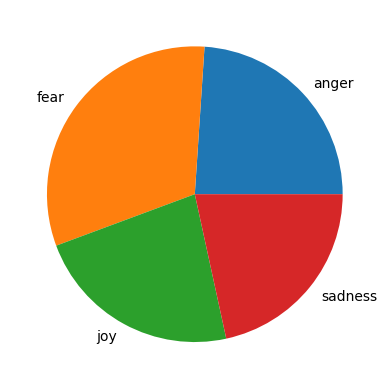

In [36]:
total = df.groupby(['sentiment']).size()

total.plot(kind='pie')

plt.show()

In [37]:
df['content_length'] = df['content'].str.len()

df.head(10)

,ID,sentiment,content,content_length
0,10941,anger,At the point today where if someone says somet...,109
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...,67
2,10943,anger,This game has pissed me off more than any othe...,115
3,10944,anger,@spamvicious I've just found out it's Candice ...,101
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,135
5,10946,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,142
6,10947,anger,wanna go home and focus up on this game . Don'...,65
7,10948,anger,@virginmedia I've been disconnected whilst on ...,117
8,10949,anger,@virginmedia I've been disconnected whilst on ...,109
9,10950,anger,I wanna see you smile I don't wanna see you ma...,56


In [38]:
def get_word_length(text):
  words = text.split()
  return len(words)

print(f"Word Length Example: {get_word_length(df['content'][0])}")

Word Length Example: 21


In [39]:
df['total_words'] = df['content'].apply(get_word_length)

df.head(10)

,ID,sentiment,content,content_length,total_words
0,10941,anger,At the point today where if someone says somet...,109,21
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...,67,8
2,10943,anger,This game has pissed me off more than any othe...,115,23
3,10944,anger,@spamvicious I've just found out it's Candice ...,101,19
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,135,21
5,10946,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,142,22
6,10947,anger,wanna go home and focus up on this game . Don'...,65,15
7,10948,anger,@virginmedia I've been disconnected whilst on ...,117,19
8,10949,anger,@virginmedia I've been disconnected whilst on ...,109,18
9,10950,anger,I wanna see you smile I don't wanna see you ma...,56,13


In [40]:
df['mean_word_length'] = df['content'].map(lambda x: np.mean([len(word) for word in x.split()]))

In [41]:
df.head(10)

,ID,sentiment,content,content_length,total_words,mean_word_length
0,10941,anger,At the point today where if someone says somet...,109,21,4.238095
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...,67,8,6.625000
2,10943,anger,This game has pissed me off more than any othe...,115,23,4.043478
3,10944,anger,@spamvicious I've just found out it's Candice ...,101,19,4.368421
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,135,21,5.428571
5,10946,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,142,22,5.500000
6,10947,anger,wanna go home and focus up on this game . Don'...,65,15,3.400000
7,10948,anger,@virginmedia I've been disconnected whilst on ...,117,19,5.210526
8,10949,anger,@virginmedia I've been disconnected whilst on ...,109,18,5.055556
9,10950,anger,I wanna see you smile I don't wanna see you ma...,56,13,3.384615


In [49]:
stop_words = stopwords.words("english")
stop_words.append("amp")

def tokenize(text):
  words = word_tokenize(text)
  return words

def remove_stopwords(words) -> [str]:
  words = [word for word in words if word not in stop_words and word.isalpha()]
  return words

def process_text(text) -> str:
  words = tokenize(text)
  words = remove_stopwords(words)

  return ' '.join(words)

In [50]:
df['content'] = df['content'].apply(process_text)
df.head(10)

,ID,sentiment,content,content_length,total_words,mean_word_length
0,10941,anger,At point today someone says something remotely...,109,21,4.238095
1,10942,anger,CorningFootball IT GAME DAY T MINUS relentless,67,8,6.625000
2,10943,anger,This game pissed game year My blood boiling Ti...,115,23,4.043478
3,10944,anger,spamvicious I found Candice Candace She pout l...,101,19,4.368421
4,10945,anger,moocowward mrsajhargreaves GaryBarlow ca come ...,135,21,5.428571
5,10946,anger,moocowward mrsajhargreaves GaryBarlow ca come ...,142,22,5.500000
6,10947,anger,wan na go home focus game Do wan na rage,65,15,3.400000
7,10948,anger,virginmedia I disconnected whilst holiday I mo...,117,19,5.210526
8,10949,anger,virginmedia I disconnected whilst holiday I mo...,109,18,5.055556
9,10950,anger,I wan na see smile I wan na see make frown,56,13,3.384615


In [51]:
words = " ".join(df['content'])

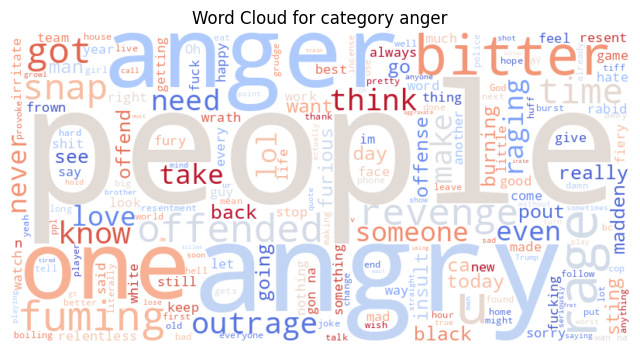

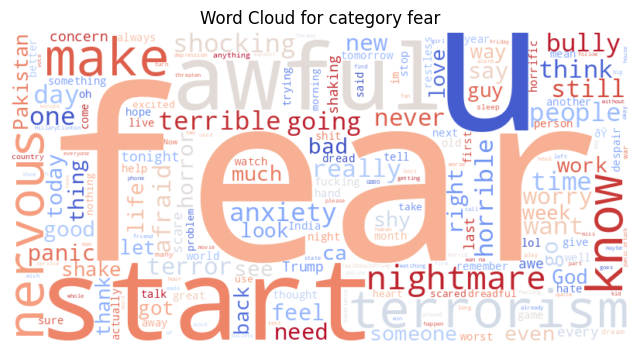

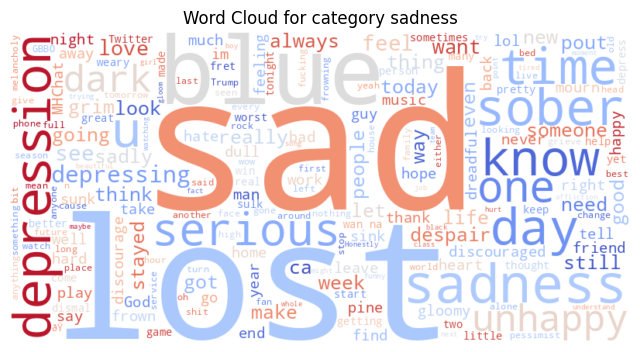

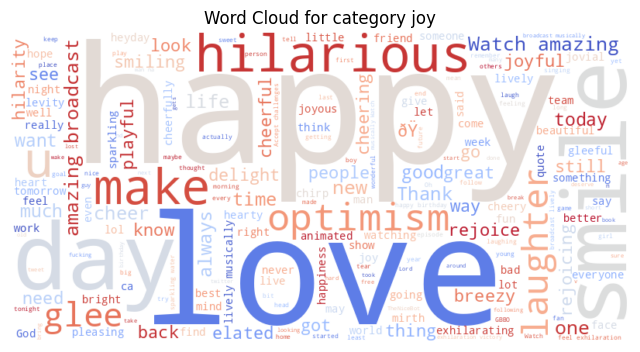

In [52]:
for category in categories:
  words = " ".join(df['content'][df['sentiment'] == category])

  wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm').generate(words)

  plt.figure(figsize=(8, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')  # Hide axes
  plt.title(f'Word Cloud for category {category}')
  plt.show()

#### Encode label.

In [53]:
label_encoder = LabelEncoder()

df['labels'] = label_encoder.fit_transform(df['sentiment'])

In [54]:
df

,ID,sentiment,content,content_length,total_words,mean_word_length,labels
0,10941,anger,At point today someone says something remotely...,109,21,4.238095,0
1,10942,anger,CorningFootball IT GAME DAY T MINUS relentless,67,8,6.625000,0
2,10943,anger,This game pissed game year My blood boiling Ti...,115,23,4.043478,0
3,10944,anger,spamvicious I found Candice Candace She pout l...,101,19,4.368421,0
4,10945,anger,moocowward mrsajhargreaves GaryBarlow ca come ...,135,21,5.428571,0
...,...,...,...,...,...,...,...
7097,40781,sadness,VivienLloyd Thank much Just home stunned happy...,102,20,4.150000,3
7098,40782,sadness,Just put winter duvet,37,7,4.285714,3
7099,40783,sadness,SilkInSide TommyJoeRatliff pretty I love sky b...,135,22,5.181818,3
7100,40784,sadness,BluesfestByron second artist announcement look...,94,10,8.500000,3


#### Training Using Bert-Based

In [55]:
MODEL_NAME = "michellejieli/emotion_text_classifier"

In [56]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, num_labels=len(label_encoder.classes_))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [57]:
dataset = Dataset.from_pandas(df[['content', 'labels']])

dataset[0]

{'content': 'At point today someone says something remotely kind waterfall burst eyes',
 'labels': 0}

In [58]:
def tokenize_words(data):
  return tokenizer(data['content'], truncation=True, padding="max_length")

def compute_metrics():

tokenized_datasets = dataset.map(tokenize_words, batched=True)

Map:   0%|          | 0/7102 [00:00<?, ? examples/s]

In [74]:
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="macro")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="macro")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

In [75]:
split_dataset = tokenized_datasets.train_test_split(test_size=0.2)

train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

In [76]:
len(train_dataset), len(test_dataset)

(5681, 1421)

In [77]:
training_arguments = TrainingArguments(
  output_dir="./emotion_model",
  evaluation_strategy="epoch",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=8,
  per_device_eval_batch_size=8,
  num_train_epochs=5,
  weight_decay=0.01,
  fp16=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [78]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
  model=model,
  args=training_arguments,
  train_dataset=train_dataset,
  eval_dataset=test_dataset,
  tokenizer=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics
)

<ipython-input-78-2f370084c7f9>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [79]:
trainer.model.device

device(type='cuda', index=0)

In [80]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.355800,0.244107,0.921886,0.922395,0.919289,0.920595
2,0.273000,0.285290,0.922590,0.921292,0.920068,0.920583
3,0.177200,0.319140,0.915552,0.912254,0.915879,0.913893
4,0.149300,0.358900,0.916256,0.913401,0.916136,0.914684
5,0.099400,0.368613,0.914849,0.911610,0.914548,0.912977


TrainOutput(global_step=3555, training_loss=0.19973397798176054, metrics={'train_runtime': 535.7936, 'train_samples_per_second': 53.015, 'train_steps_per_second': 6.635, 'total_flos': 3763071974138880.0, 'train_loss': 0.19973397798176054, 'epoch': 5.0})

In [81]:
trainer.evaluate()

{'eval_loss': 0.36861342191696167,
 'eval_accuracy': 0.9148486980999296,
 'eval_precision': 0.911609757265551,
 'eval_recall': 0.9145477206715453,
 'eval_f1': 0.9129767666941246,
 'eval_runtime': 5.8899,
 'eval_samples_per_second': 241.26,
 'eval_steps_per_second': 30.221,
 'epoch': 5.0}